In [121]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra

In [122]:
# Squared-exponential covariance function
sqexp_cov_fn(D, phi) = @. exp(-D^2 / (2*phi)) 
# Exponential covariance function
exp_cov_fn(D, phi) = @. exp(-D / phi)
# Exponential covariance function
sqexp_cov_fn2(D, n, l, eps=1e-1) = @.(n*exp(-D^2/(2*l))) + LinearAlgebra.I * eps

sqexp_cov_fn2 (generic function with 2 methods)

In [123]:
@model function marginal_GP(y, X, m=0, s=1, cov_fn=sqexp_cov_fn)
    # Dimensions of predictors .
    N, P = size(X)
    
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Priors.
    mu ~ Normal(m, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)
    
    # Realized covariance function
    K = cov_fn(D, phi)
    y ~ MvNormal(mu * ones(N), K + sig2 * LinearAlgebra.I(N))
end

marginal_GP (generic function with 4 methods)

In [107]:
@model function latent_GP(y, X, m=0, s=1, cov_fn=exp_cov_fn)
    # Dimensions of predictors .
    N, P = size(X)
    
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Priors.
    mu ~ Normal(0, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)
    
    # Nodes
    meann = MvNormal(zeros(N), ones(N))
    K = cov_fn(D, phi) + sig2 * LinearAlgebra.I(N)
    R = cholesky(K).U
    
    y = R * meann
end

latent_GP (generic function with 4 methods)

In [108]:
"""
@model function latent_GP(y, X, cov_fn=sqexp_cov_fn2)
    # Dimensions of predictors .
    N, P = size(X)
    
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Hyper-Priors.
    n ~ LogNormal(0, 1)
    l ~ Uniform(0, 1)
    
    # Nodes
    nodes = MvNormal(zeros(N), ones(N))
    
    # Realized covariance function
    K = cov_fn(D, n, l)
    
    # Sampling Distribution.
    # The latent variables have been marginalized out here,
    # so there's only one level.
    y ~ K_mat .* nodes
end
"""

"@model function latent_GP(y, X, cov_fn=sqexp_cov_fn2)\n    # Dimensions of predictors .\n    N, P = size(X)\n    \n    # Distance matrix.\n    D = pairwise(Distances.Euclidean(), X, dims=1)\n    \n    # Hyper-Priors.\n    n ~ LogNormal(0, 1)\n    l ~ Uniform(0, 1)\n    \n    # Nodes\n    nodes = MvNormal(zeros(N), ones(N))\n    \n    # Realized covariance function\n    K = cov_fn(D, n, l)\n    \n    # Sampling Distribution.\n    # The latent variables have been marginalized out here,\n    # so there's only one level.\n    y ~ K_mat .* nodes\nend\n"

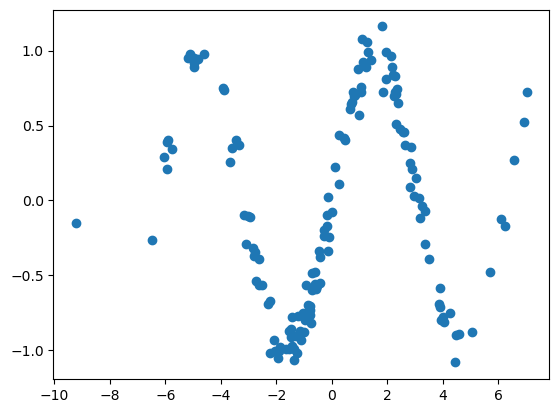

PyObject <matplotlib.collections.PathCollection object at 0x7f16299fb520>

In [109]:
N = 150
X = randn(N, 1) * 3
y = sin.(vec(X)) + randn(N) * 0.1
plt.scatter(vec(X), y)


In [110]:
chain2 = sample(latent_GP(y, X), MH(), 200)

LoadError: MethodError: no method matching X_A_Xt(::PDMats.PDiagMat{Float64, Vector{Float64}}, ::UpperTriangular{Float64, Matrix{Float64}})
[0mClosest candidates are:
[0m  X_A_Xt(::PDMats.PDiagMat, [91m::StridedMatrix{T} where T[39m) at ~/.julia/packages/PDMats/G0Prn/src/pdiagmat.jl:129

In [124]:
chain = sample(marginal_GP(y, X), HMC(0.01, 100), 200)

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:53


Chains MCMC chain (200×12×1 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 1
Samples per chain = 200
parameters        = mu, phi, sig2
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64 

          mu    0.1166    0.4073     0.0288    0.0103   -2394.7954    0.9956
         phi    3.6769    0.7120     0.0503    0.1360      56.4547    1.0322
        sig2    0.0134    0.0166     0.0012    0.0019      57.8378    1.0087

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          mu   -0.6985   -0.1585    0.1390    0.4076    0.8468
         phi    2.2021    3.3020    3.6937    4.0762    5.1031
        sig2    0.0091  

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364


In [129]:
mu = group(chain, :mu).value.data[:, :, 1]
sig2 = group(chain, :sig2).value.data[:, :, 1]
phi = group(chain, :phi).value.data[:, :, 1];

In [136]:
function make_gp_predict_fn(Xnew, y, X, cov_fn)
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)
    
    return (mu, sig2, phi) -> let
        K = cov_fn(D, phi) + sig2 * LinearAlgebra.I
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * (y .- mu) .+ mu
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        mvn = MvNormal(m, S)
        rand(mvn)
    end
end

make_gp_predict_fn (generic function with 1 method)

In [137]:
Xnew = sort(randn(N, 1) * 4, dims=1)
gp_predict = make_gp_predict_fn(Xnew, y, X, sqexp_cov_fn)
ynew = [gp_predict(mu[m], sig2[m], phi[m]) for m in 1:length(mu)]
ynew = hcat(ynew...);

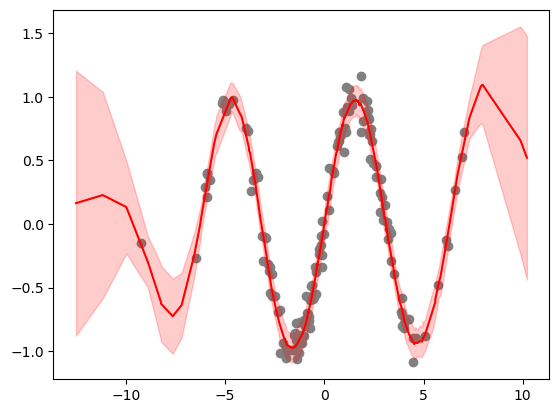

In [138]:
pred_mean = mean(ynew, dims=2)
pred_std = std(ynew, dims=2)

plt.plot(vec(Xnew), vec(pred_mean), color="red", label="Posterior predictive mean")
plt.scatter(vec(X), vec(y), color="grey", label="Data")
plt.fill_between(vec(Xnew), vec(pred_mean .+ pred_std), vec(pred_mean .- pred_std), color="red", alpha=0.2)
#plt.legend(loc="lower right")
#plt.title("GP Posterior predictive with 95% credible interval");